In [3]:
from pathlib import Path
from typing import Iterable, List, Callable, Optional
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
from torch import nn
import torch

root = Path('../data/dset-s2')
assert root.exists()

In [4]:
def scale(item: dict):
    item['image'] = item['image'] / 10000
    return item

In [5]:
train_imgs = RasterDataset(root=(root/'tra_scene').as_posix(), crs='epsg:3395', res=10, transforms=scale)
train_msks = RasterDataset(root=(root/'tra_truth').as_posix(), crs='epsg:3395', res=10)

valid_imgs = RasterDataset(root=(root/'val_scene').as_posix(), crs='epsg:3395', res=10, transforms=scale)
valid_msks = RasterDataset(root=(root/'val_truth').as_posix(), crs='epsg:3395', res=10)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size=512, length=260, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=512, length=128, units=Units.PIXELS)

In [6]:
train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=8, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=8, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [6]:
def calc_statistics(dset: RasterDataset):
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds.
        For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """

        # To avoid loading the entire dataset in memory, we will loop through each img
        # The filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # Reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rio.open(file).read()/10000 #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)

In [7]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: List[float], stdev: List[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if inputs["image"].ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.

        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs["image"][:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs


In [8]:
normalize = MyNormalize(*calc_statistics(train_imgs))

tfms = torch.nn.Sequential(
    indices.AppendNDWI(index_green=1, index_nir=3),
    indices.AppendNDWI(index_green=1, index_nir=5),
    indices.AppendNDVI(index_nir=3, index_red=2),
    normalize
)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [9]:
def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Blues')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:
      

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

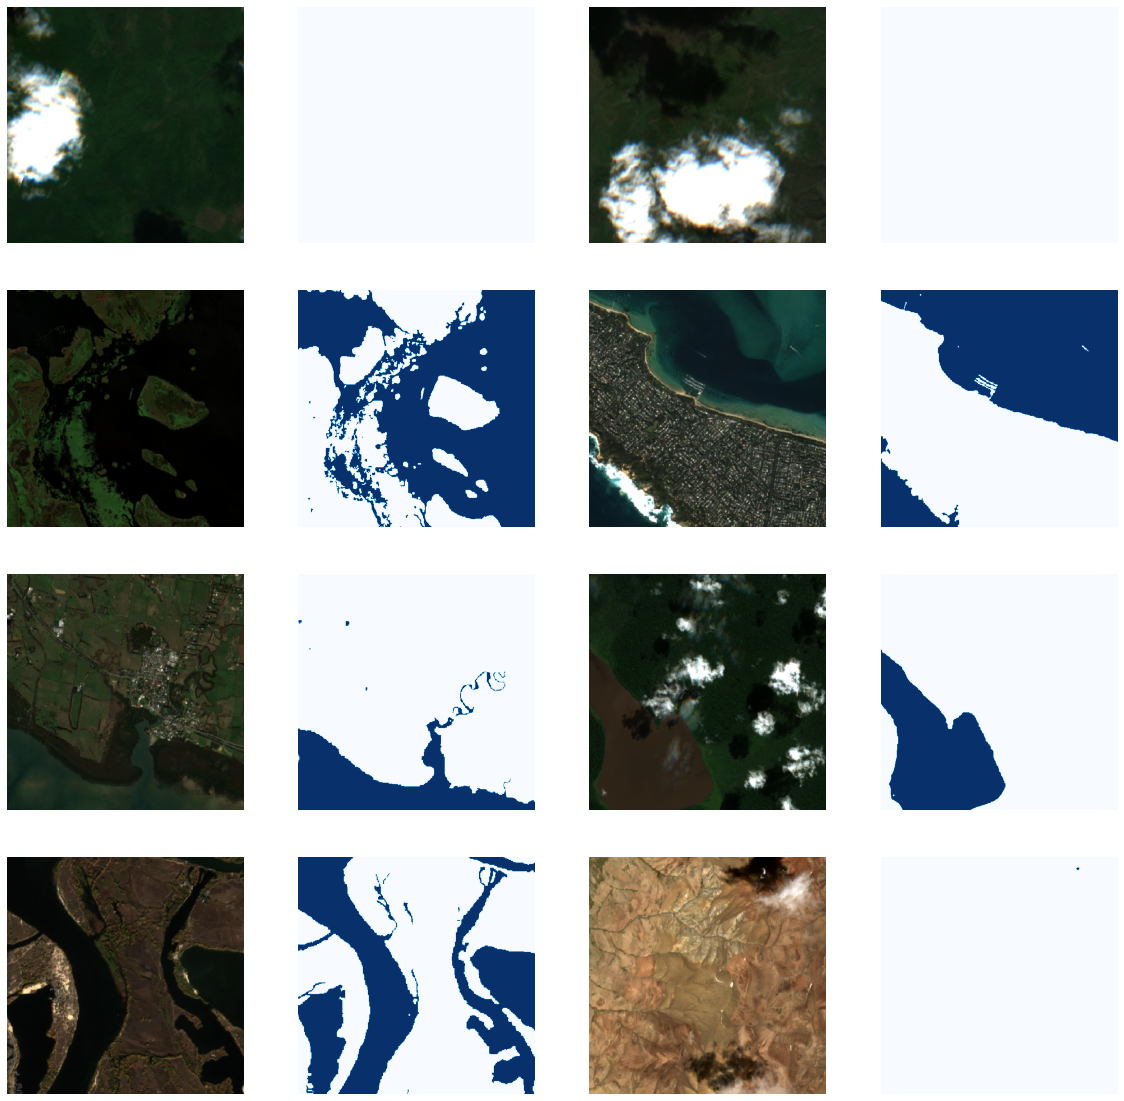

In [10]:
plot_batch(valid_batch)

In [11]:
valid_batch_tfmd = tfms(valid_batch)

In [12]:
valid_batch_tfmd['image'].shape

torch.Size([8, 9, 512, 512])

In [13]:
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(weights=None, num_classes=2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/user/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
backbone = model.get_submodule('backbone')

conv = nn.modules.conv.Conv2d(
    in_channels=9, 
    out_channels=64, 
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
backbone.register_module('conv1', conv)

pred = model(torch.randn(3, 9, 512, 512))
pred['out'].shape

torch.Size([3, 2, 512, 512])

In [15]:
def train_loop(
    epochs: int, 
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    batch_tfms: Optional[Callable]=None
):
    # size = len(dataloader.dataset)
    cuda_model = model.cuda()

    for epoch in range(epochs):
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                batch = batch_tfms(batch)

            X = batch['image'].cuda()
            y = batch['mask'].type(torch.long).cuda()
            pred = cuda_model(X)['out']
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)

        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        batch = batch_tfms(batch)                    

                    X = batch['image'].type(torch.float32).cuda()
                    y = batch['mask'].type(torch.long).cuda()

                    pred = cuda_model(X)['out']

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Accs={[round(a, 3) for a in acc]}')
        else:

            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

In [16]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t.squeeze())

In [17]:
#%%time
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
#train_loop(2, train_dataloader, valid_dataloader, model, loss, optimizer, 
#           acc_fns=[oa, iou], batch_tfms=tfms)

In [18]:
%%time
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
train_loop(2, train_dataloader, valid_dataloader, model, loss, optimizer, 
           acc_fns=[oa, iou], batch_tfms=tfms)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 3.94 GiB total capacity; 3.24 GiB already allocated; 103.69 MiB free; 3.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF